In [1]:
#predict how many
#proportion for hotspots
#probability for a particular hotspots
#visualization

In [2]:
import glob
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import datetime
import seaborn as sns

In [ ]:
# The weather data uses in this project is powered by Dark Sky. See https://darksky.net/poweredby/ for more info.
#from darksky import forecast

In [ ]:
#nashville = forecast(key, 36.133,-86.756)

In [ ]:
#nashville['currently']

In [ ]:
#NOTE TO SELF: I can get up to 40,000 places encoded or reverse-encoded for free each month.
#import googlemaps
#from datetime import datetime

In [ ]:
#gmaps = googlemaps.Client()

In [ ]:
#gmaps.reverse_geocode((36.132937, -86.755738))

### Project Outline
#### Deliverable General Description:
* A Qlik app that will explore crash data for Metro Nashville from 2013-present and forecast where (deadly?) crashes are most likely to occur over the next ? hours given the hourly weather forecast
#### Datasets:
* Crash Data from data.nashville.gov for 2013-present
* Weather data from Dark Sky
* Possibly TDOT daily average volumes for various locations around Davidson County??
* Imputing location data from Google Geocoding API
#### General Strategy:
* Read in and clean the data
* Extract features from the timestamps, addresses, weather, and lighting
* Use Qlik to do exploratory data analysis on the data
* Use a RandomForest model to forecast where crashes are most likely to occur. 

### Read in and clean the data:

In [3]:
path ='data'
allFiles = glob.glob(path + "/Crash_Data_*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    if file_ != "data/Crash_Data_2018.csv":
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
crash_data_df = pd.concat(list_)

In [4]:
crash_data_df.columns

Index(['Accident Number', 'Date and Time', 'Number of Motor Vehicles',
       'Number of Injuries', 'Number of Fatalities', 'Property Damage',
       'Hit and Run', 'Reporting Officer', 'Collision Type',
       'Collision Type Description', 'Weather', 'Weather Description',
       'Illumination', 'Illumination Description', 'Harmful Codes',
       'Harmful Codes Description', 'Street Address', 'City', 'State', 'Zip',
       'RPA', 'Precinct', 'Latitude', 'Longitude', 'Mapped Location'],
      dtype='object')

In [5]:
crash_data_df = crash_data_df.reset_index().drop('index', axis=1)
#crash_data_df.fillna('missing', inplace=True)

#### Git rid of nulls

In [21]:
crash_data_df.

array([[20110822774, Timestamp('2017-03-29 07:21:00'), 2.0, ..., 0, 1, 0],
       [20150551770, Timestamp('2017-06-23 12:49:00'), 4.0, ..., 0, 0, 0],
       [20160003224, Timestamp('2017-01-02 09:55:00'), 1.0, ..., 0, 1, 0],
       ..., 
       ['20131149183', Timestamp('2013-12-11 22:50:00'), 1.0, ..., 0, 0, 0],
       ['20131092942', Timestamp('2013-11-26 02:20:00'), 1.0, ..., 0, 0, 0],
       ['20131090623', Timestamp('2013-11-25 10:51:00'), 2.0, ..., 0, 0, 0]], dtype=object)

In [6]:
crash_data_df['Date and Time'] = pd.to_datetime(crash_data_df['Date and Time'])

In [7]:
crash_data_df['Day Of Week'] = [timestamp.dayofweek for timestamp in crash_data_df['Date and Time']]
crash_data_df['Day Of Month'] = [timestamp.day for timestamp in crash_data_df['Date and Time']]
crash_data_df['Month'] = [timestamp.month for timestamp in crash_data_df['Date and Time']]
crash_data_df['Hour'] = [timestamp.hour for timestamp in crash_data_df['Date and Time']]
crash_data_df['Year'] = [timestamp.year for timestamp in crash_data_df['Date and Time']]
crash_data_df['Week Of Year'] = [timestamp.isocalendar()[1] for timestamp in crash_data_df['Date and Time']]
crash_data_df['Weekend'] = [1 if timestamp.dayofweek in [5,6] else 0 for timestamp in crash_data_df['Date and Time']]

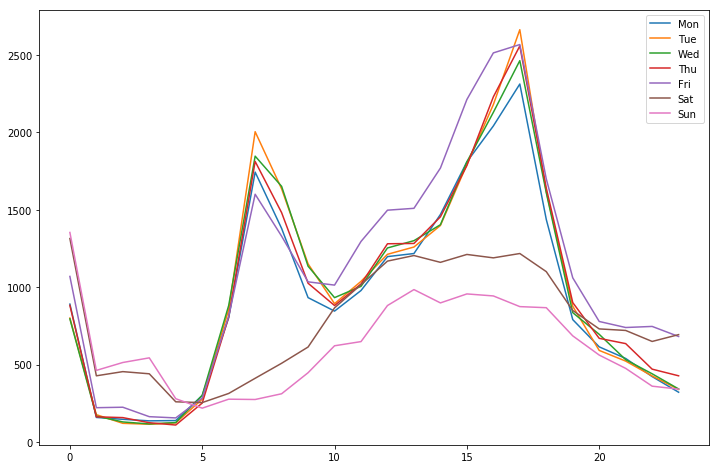

In [8]:
plt.figure(figsize=(12,8))
days_of_week = sorted(crash_data_df['Day Of Week'].unique())
named_days_of_week = dict(zip(sorted(crash_data_df['Day Of Week'].unique()), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
hours_of_day = sorted(crash_data_df['Hour'].unique())

# plot of trends by hour for Friday (years combined)
for day in days_of_week:
    plt.plot(hours_of_day, 
             crash_data_df[crash_data_df['Day Of Week'] == day].groupby(['Hour'])['Accident Number'].count(), 
             label=named_days_of_week[day])
plt.legend()
#plt.xlim([5, 10])
plt.show()

In [9]:
# Create column for Rush Hour Morning
temp = []

for hour, weekend_code in list(zip(crash_data_df['Hour'], crash_data_df['Weekend'])):
    if (hour in range(6,10)) & (weekend_code == 0):
        temp.append(1)
    else:
        temp.append(0)
        
crash_data_df['Rush Hour Morning'] = temp

In [10]:
# Create column for Rush Hour Afternoon
temp = []

for hour, weekend_code in list(zip(crash_data_df['Hour'], crash_data_df['Weekend'])):
    if (hour in range(15,19)) & (weekend_code == 0):
        temp.append(1)
    else:
        temp.append(0)
        
crash_data_df['Rush Hour Afternoon'] = temp

In [11]:
crash_data_df[crash_data_df['Rush Hour Morning'] == 1]['Accident Number'].count()

25931

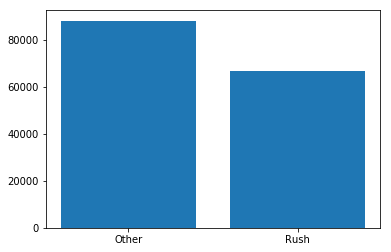

In [12]:
# plot of trends by week (years combined)
plt.bar(['Rush', 'Other'], 
         [crash_data_df[crash_data_df['Rush Hour Morning'] == 1]['Accident Number'].count() +
         crash_data_df[crash_data_df['Rush Hour Afternoon'] == 1]['Accident Number'].count(),
         crash_data_df[(crash_data_df['Rush Hour Morning'] == 0) & (crash_data_df['Rush Hour Afternoon'] == 0)]['Accident Number'].count()])
plt.show()

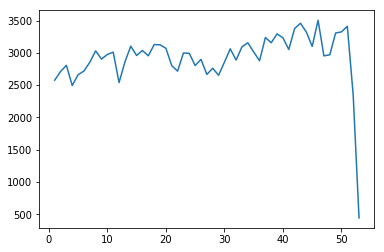

In [13]:
# plot of trends by week (years combined)
plt.plot(sorted(crash_data_df['Week Of Year'].unique()), 
         crash_data_df[(crash_data_df['Year'] != 2018)].groupby(['Week Of Year'])['Accident Number'].count())
plt.show()

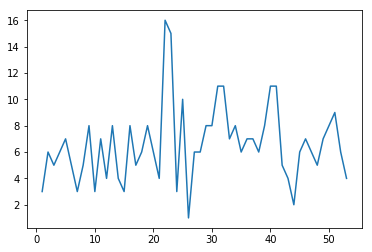

In [14]:
# plot of trends by week (years combined)
plt.plot(sorted(crash_data_df['Week Of Year'].unique()), 
         crash_data_df[(crash_data_df['Year'] != 2018) & (crash_data_df['Number of Fatalities'] > 0)].groupby(['Week Of Year'])['Accident Number'].count())
plt.show()

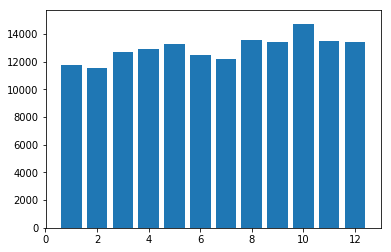

In [15]:
# plot of trends by month (years combined)
plt.bar(sorted(crash_data_df['Month'].unique()), 
         crash_data_df[crash_data_df['Year'] != 2018].groupby(['Month'])['Accident Number'].count())
plt.ylim([0,max(crash_data_df.groupby(['Month'])['Accident Number'].count()) + 1000])
plt.show()

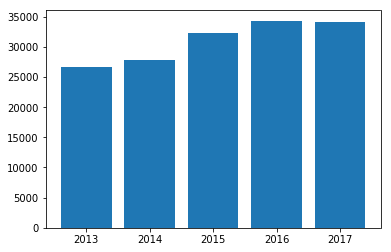

In [16]:
# plot of trends by year
plt.bar(sorted(crash_data_df['Year'].unique()), 
         crash_data_df.groupby(['Year'])['Accident Number'].count())
plt.show()

In [ ]:
crash_data_df.to_csv('~/Desktop/All_Crash_Data.csv')

In [ ]:
#crash_df_harm_list = []
#for entry in crash_data_df['Harmful Codes Description']:
#    temp = entry.split(';')
#    crash_df_harm_list.append(temp)

#crash_data_df['Harmful Codes Description'] = crash_df_harm_list
#crash_data_df

#### Things to do:
* DataTypes:
    * "Date and Time" to dates
* Round lats and longs to 3 decimal places
* Drop the following fields:
    * accident number
    * reporting officer
    * RPA
* Engineer the following features:
    * Timestamp:
        * hour_of_day
        * day_of_week
        * week_of_year
        * year
        * is_weekend
        * is_rush_hour
        * is_holiday
        * is_daytime (if I pull in sunrise/sunset info...)
        * is_lighted
        * time buckets for: 5-10AM, 10AM-2PM, 2-6PM, 6-11PM, 12-5AM
    * Fatalities:
        * is_fatality_or_injury_involved
        * is
    * Harmful Codes?:
        * not sure how to handle this yet, but I know I need to split out the multiple items into different columns (maybe just say "if it has code x then put a 'y' in the column named 'is_x'"? That way I can decide which descriptions are the important ones or can more easily bucket them)
    * Location:
        * Lat/Long buckets?
        * is_downtown
        * is_interstate
        * is_intersection
        * is_secondary_stretch
    * Weather:
        * is_wet_weather
        * is_windy
        * is_foggy
        * is_clear
    * 

In [ ]:
#crash_df_harm_codes_list = []
#for entry in crash_data_df['Harmful Codes']:
#    temp = entry.split(';')
#    crash_df_harm_codes_list.append(temp)

#crash_data_df['Harmful Codes'] = crash_df_harm_codes_list
#crash_data_df

In [ ]:
#crash_data_df.loc[:,'Harmful Codes':'Harmful Codes Description']
#for entry in crash_data_df['Harmful Codes']:

#{crash_data_df['Harmful Codes'][idx][0]: crash_data_df['Harmful Codes Description'][idx][0] for idx in range(len(crash_data_df))}

In [ ]:
#crash_data_df['Property Damage'].unique()

In [ ]:
#crash_data_df['Harmful Codes Description'][1]

In [ ]:
#crash_data_df['Harmful Codes Description']

In [ ]:
crash_data_df.columns

In [ ]:
crash_data_df['Weather Description'].unique().tolist()

In [ ]:
temp_list = []
for row in crash_data_df['Street Address']:
    if '&' in row:
        streets = row.split('&')
        temp_list.append({streets[0].strip(), streets[1].strip()})
    else:
        temp_list.append({row})

crash_data_df['Street/Intersection'] = temp_list

#for row in crash_data_2013_df.iterrows():
#    if '&' in row['Street Address']:
#        streets = address.split('&')
#        row['Street/Intersection'] = ({streets[0].strip(), streets[1].strip()})
#    else:
#        row['Street/Intersection'] = ({wreck['Street Address']})


In [ ]:
crash_data_df

In [ ]:
crash_data_df

In [ ]:
crash_data_df = crash_data_df[(crash_data_df['Latitude'] != 0) & (crash_data_df['Longitude'] != 0)]

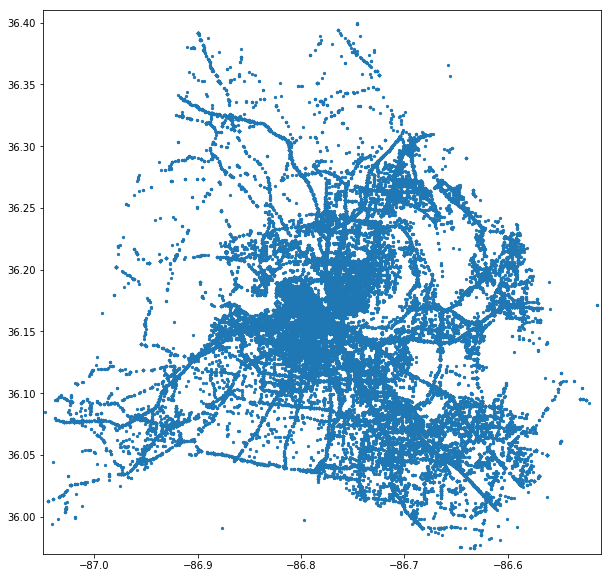

In [17]:
plt.figure(figsize=[10,10])
plt.xlim([-87.05, -86.51]) #.54 units
plt.ylim([35.97, 36.41]) # .44 units 
plt.scatter(crash_data_df.Longitude, crash_data_df.Latitude, alpha=1, s=5)
plt.show()

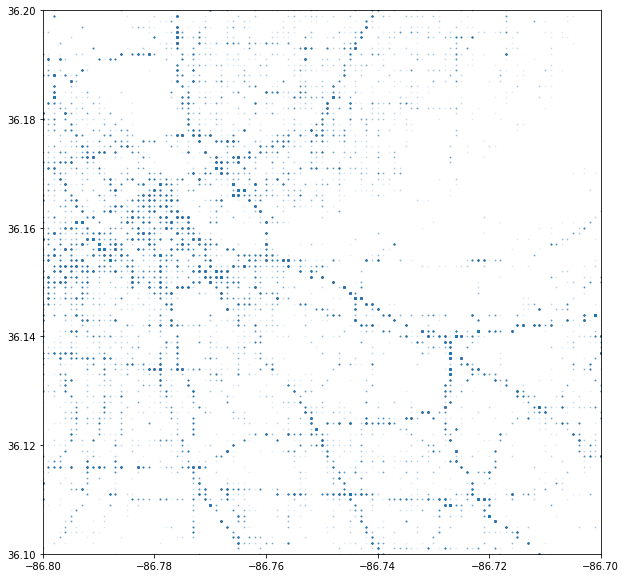

In [18]:
plt.figure(figsize=[10,10])
plt.xlim([-86.8, -86.7])
plt.ylim([36.1, 36.2])
plt.scatter(round(crash_data_df.Longitude, 3), round(crash_data_df.Latitude, 3), alpha=0.1, s=0.8)
plt.show()